In [0]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.autograd.variable import Variable


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import math
import time


In [0]:
#dealing with the data


# Dataset responsible for manipulating data for training as well as training tests.
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    

BATCH_SIZE = 10
VALID_SIZE = 0.01 # percentage of data for validation

#better way of spliting the data:
#transformation
transform_data = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomRotation(degrees=(-20, 20)), #rotating the image random degree from -20 to 20
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

dataset = DatasetMNIST(data = pd.read_csv('train.csv'), transform=transform_data)

#len of dataset
len_dataset = len(dataset)

#spliting train and validation
train_data, valid_data = random_split(dataset, [int((1-VALID_SIZE)*len_dataset), int(VALID_SIZE*len_dataset)])

#defining the loaders
#here each element is the mini batch
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(dataset = valid_data, batch_size = BATCH_SIZE, shuffle = True)

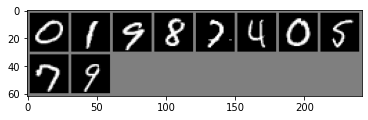

In [3]:
#classes
classes = [str(i) for i in range(0,10)]


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out.cuda()
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x).cuda()
        return out

In [5]:
discriminator = Discriminator()
generator = Generator()

if torch.cuda.is_available():
    print("Using CUDA")
    discriminator.cuda()
    generator.cuda()

criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

Using CUDA


In [0]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score



def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [0]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100)).cuda()

In [0]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)

for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images).cuda()
        real_labels = Variable(torch.ones(images.size(0))).cuda()
        
        # Sample from generatortrain_discriminator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()

        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0))).cuda()
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)

        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            #plt.show()
            

            if epoch % 10 == 0:

              plt.savefig('imagens2/mnist-gan-%03d-.png'%epoch)



            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, g_loss.data,
                    real_score.data.mean(), fake_score.data.mean()))

#fig.close()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [1/200], Step[100/4158], d_loss: 0.0872, g_loss: 3.6204, D(x): 0.99, D(G(z)): 0.07
Epoch [1/200], Step[200/4158], d_loss: 0.3197, g_loss: 3.3656, D(x): 0.82, D(G(z)): 0.11
Epoch [1/200], Step[300/4158], d_loss: 0.6373, g_loss: 2.0891, D(x): 0.72, D(G(z)): 0.15
Epoch [1/200], Step[400/4158], d_loss: 2.7147, g_loss: 0.2582, D(x): 0.34, D(G(z)): 0.70
Epoch [1/200], Step[500/4158], d_loss: 1.9500, g_loss: 0.7261, D(x): 0.38, D(G(z)): 0.54
Epoch [1/200], Step[600/4158], d_loss: 2.4878, g_loss: 0.4655, D(x): 0.41, D(G(z)): 0.73
Epoch [1/200], Step[700/4158], d_loss: 1.4968, g_loss: 0.6170, D(x): 0.54, D(G(z)): 0.57
Epoch [1/200], Step[800/4158], d_loss: 0.8827, g_loss: 1.6756, D(x): 0.62, D(G(z)): 0.22
Epoch [1/200], Step[900/4158], d_loss: 1.1864, g_loss: 1.2140, D(x): 0.60, D(G(z)): 0.45
Epoch [1/200], Step[1000/4158], d_loss: 1.3466, g_loss: 2.0732, D(x): 0.55, D(G(z)): 0.44
Epoch [1/200], Step[1100/4158], d_loss: 1.0145, g_loss: 1.1713, D(x): 0.64, D(G(z)): 0.39
Epoch [1/200], Step

In [0]:
outputs